# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe

def load_json_to_dataframe(json_path):
    # Load the JSON data
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Convert to DataFrame
    df = pd.DataFrame(data)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# read the json file by giving the file path and create a dataframe

# Load the dataset
json_path = 'ingredient_and_quantity.json'
df = load_json_to_dataframe(json_path)

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [7]:
# display first five rows of the dataframe - df

df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [8]:
# print the dimensions of dataframe - df

print("DataFrame dimensions:", df.shape)

DataFrame dimensions: (285, 2)


In [9]:
# print the information of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [10]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: x.split())

# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

In [11]:
# display first five rows of the dataframe - df

df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [12]:
# create input_length and pos_length columns for the input_tokens and pos-tokens

df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [13]:
# check for the equality of input_length and pos_length in the dataframe

# Check for rows where lengths are not equal
mismatch_df = df[df['input_length'] != df['pos_length']]

# Print number of mismatches
print("Number of mismatched rows:", len(mismatch_df))

# Verify aligned lengths
all_aligned = (df['input_length'] == df['pos_length']).all()
print("All rows aligned:", all_aligned)

Number of mismatched rows: 5
All rows aligned: False


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [14]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it

def unique_labels(df):
    all_labels = [label for sublist in df['pos_tokens'] for label in sublist]
    unique_labels = set(all_labels)
    print("Unique POS Labels:")
    for label in unique_labels:
        print(label)

unique_labels(df)

Unique POS Labels:
ingredient
quantity
unit


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [15]:
# drop the irrelevant recipe data

clean_df = df[df['input_length'] == df['pos_length']].copy()

In [16]:
# drop rows with missing/ empty values in columns

clean_df.dropna(subset=['input', 'pos', 'input_tokens', 'pos_tokens'], inplace=True)
clean_df = clean_df[clean_df['input_tokens'].str.len() > 0]
clean_df = clean_df[clean_df['pos_tokens'].str.len() > 0]

# keep rows with 'ingredient' in POS tags only

clean_df = clean_df[clean_df['pos_tokens'].apply(lambda x: 'ingredient' in x)]

In [17]:
print(f"Number of Valid recipes: {len(clean_df)}")

Number of Valid recipes: 280


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [18]:
# update the input and pos length in input_length and pos_length

clean_df['input_length'] = clean_df['input_tokens'].apply(len)
clean_df['pos_length'] = clean_df['pos_tokens'].apply(len)

clean_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablesp

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [19]:
# validate the input length and pos length as input_length and pos_length

mismatch_df = clean_df[clean_df['input_length'] != clean_df['pos_length']]
all_aligned = (clean_df['input_length'] == clean_df['pos_length']).all()

print("Number of mismatched rows:", len(mismatch_df))
print("All rows aligned:", all_aligned)

Number of mismatched rows: 0
All rows aligned: True


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [20]:
# split the dataset into training and validation sets

train_df, val_df = train_test_split(clean_df, test_size=0.3, random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [21]:
# print the first five rows of train_df

train_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length
179                                                        250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric                                                                                                                        quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
57   200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil  quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient  [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ing

In [22]:
# print the first five rows of the val_df

val_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length
35                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15
111  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi P

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [23]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [24]:
# validate the shape of training and validation samples

print(f"X_train samples: {len(X_train)}, y_train samples: {len(y_train)}")
print(f"X_val samples: {len(X_val)}, y_val samples: {len(y_val)}")

X_train samples: 196, y_train samples: 196
X_val samples: 84, y_val samples: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [25]:
# Display the number of unique labels present in y_train

all_y_train_labels = [label for sublist in y_train for label in sublist]

unique_y_train_labels_count = len(set(all_y_train_labels))

unique_y_train_labels_list = sorted(list(set(all_y_train_labels)))

print(f"Number of unique labels in y_train: {unique_y_train_labels_count}")
print("List of unique labels in y_train:", unique_y_train_labels_list)

Number of unique labels in y_train: 3
List of unique labels in y_train: ['ingredient', 'quantity', 'unit']


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [26]:
# flatten the list for nested_list (input_tokens, pos_tokens)

def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

dataset_name = 'Training'

# Flatten the lists
flat_input_tokens = flatten_list(X_train)
flat_pos_tokens = flatten_list(y_train)

print(f"Total input tokens: {len(flat_input_tokens)}")
print(f"Total POS labels: {len(flat_pos_tokens)}")

Total input tokens: 7114
Total POS labels: 7114


In [27]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [28]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

def extract_and_validate_tokens(df, dataset_name):
    # Flatten the lists within the dataframe (if not already flattened)
    flat_input_tokens = flatten_list(df['input_tokens'].tolist())
    flat_pos_tokens = flatten_list(df['pos_tokens'].tolist())


    print(f"Length of flattened input_tokens: {len(flat_input_tokens)}")
    print(f"Length of flattened pos_tokens: {len(flat_pos_tokens)}")

    # Validate lengths
    if len(flat_input_tokens) == len(flat_pos_tokens):
        print("Length of flattened input_tokens and pos_tokens are equal.")
    else:
        print("WARNING: Length of flattened input_tokens and pos_tokens are NOT equal.")

    # Display first 10 records
    print("\nFirst 10 flattened input_tokens:")
    print(flat_input_tokens[:10])

    print("\nFirst 10 flattened pos_tokens:")
    print(flat_pos_tokens[:10])

In [29]:
# extract the tokens and its pos tags
extract_and_validate_tokens(train_df, dataset_name)

Length of flattened input_tokens: 7114
Length of flattened pos_tokens: 7114
Length of flattened input_tokens and pos_tokens are equal.

First 10 flattened input_tokens:
['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']

First 10 flattened pos_tokens:
['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [30]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    ingredient_list = []
    unit_list = []
    quantity_list = []

    # Validate that tokens and pos_tags have the same length
    if len(tokens) != len(pos_tags):
        warnings.warn("Token list and POS tag list have different lengths.")
        return [], [], []

    # Validate that all labels are in the expected set
    expected_labels = {'ingredient', 'unit', 'quantity'}
    if not all(tag in expected_labels for tag in pos_tags):
         warnings.warn("Unexpected labels found in pos_tags.")
         return [], [], []

    for token, pos_tag in zip(tokens, pos_tags):
        if pos_tag == 'ingredient':
            ingredient_list.append(token)
        elif pos_tag == 'unit':
            unit_list.append(token)
        elif pos_tag == 'quantity':
            quantity_list.append(token)

    return ingredient_list, unit_list, quantity_list

In [31]:
#  call the function to categorise the labels into respective list

train_ingredients, train_units, train_quantities = categorize_tokens(flat_input_tokens, flat_pos_tokens)

print(f"Number of training ingredients: {len(train_ingredients)}")
print(f"Number of training units: {len(train_units)}")
print(f"Number of training quantities: {len(train_quantities)}")

# Display first few items from each list
print("\nFirst 10 training ingredients:")
print(train_ingredients[:10])
print("\nFirst 10 training units:")
print(train_units[:10])
print("\nFirst 10 training quantities:")
print(train_quantities[:10])

Number of training ingredients: 5323
Number of training units: 811
Number of training quantities: 980

First 10 training ingredients:
['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely']

First 10 training units:
['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']

First 10 training quantities:
['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [32]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    # Use Counter to count item frequencies
    item_counts = Counter(item_list)

    # Get the top N most common items
    top_items = item_counts.most_common(top_n)

    print(f"\nTop {top_n} Most Frequent {pos_label}s in {dataset_name} Dataset:")
    for item, count in top_items:
        print(f"{item}: {count}")

    return top_items

In [33]:
# get the top ingredients which are frequently seen in the recipe

get_top_frequent_items(train_ingredients, 'Ingredient', dataset_name)


Top 10 Most Frequent Ingredients in Training Dataset:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


[('powder', 129),
 ('Salt', 102),
 ('seeds', 89),
 ('Green', 85),
 ('chopped', 84),
 ('Oil', 83),
 ('Red', 81),
 ('Chilli', 77),
 ('Coriander', 71),
 ('Sunflower', 65)]

In [34]:
# get the top units which are frequently seen in the recipe

get_top_frequent_items(train_units, 'Unit', dataset_name)


Top 10 Most Frequent Units in Training Dataset:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


[('teaspoon', 162),
 ('cup', 136),
 ('tablespoon', 99),
 ('grams', 63),
 ('tablespoons', 61),
 ('inch', 52),
 ('cups', 50),
 ('sprig', 41),
 ('cloves', 39),
 ('teaspoons', 39)]

#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [35]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

def plot_top_items(top_item_list, label, dataset_name):
    items = [item for item, count in top_item_list]
    counts = [count for item, count in top_item_list]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=items, palette='viridis')
    plt.xlabel('Frequency')
    plt.ylabel(label)
    plt.title(f'Top {len(top_item_list)} Most Frequent {label}s in {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---




Top 10 Most Frequent Ingredients in Training Dataset:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


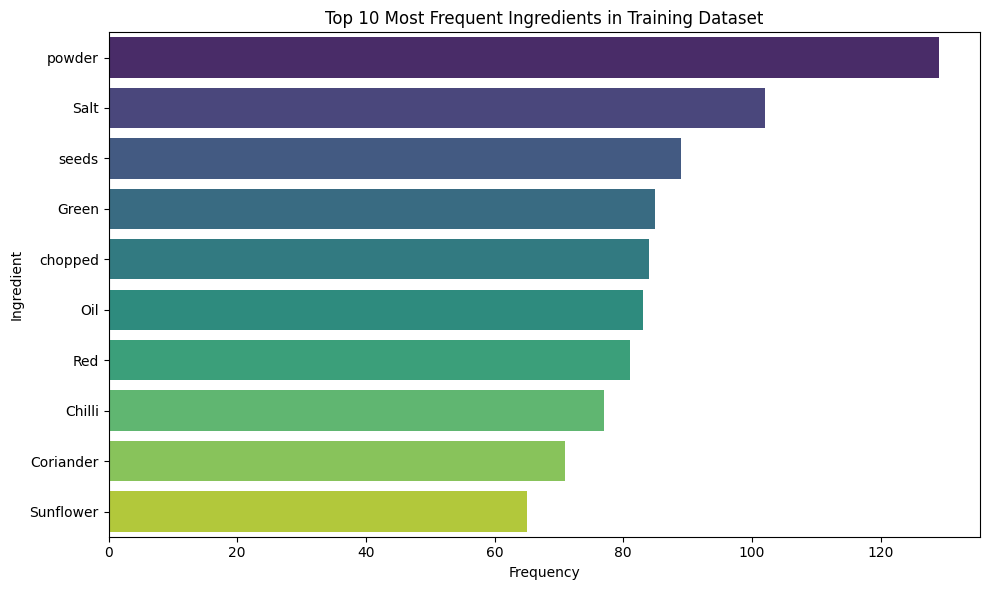

In [36]:
# plot the top frequent ingredients in training data

top_train_ingredients = get_top_frequent_items(train_ingredients, 'Ingredient', dataset_name)

plot_top_items(top_train_ingredients, 'Ingredient', dataset_name)


Top 10 Most Frequent Units in Training Dataset:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


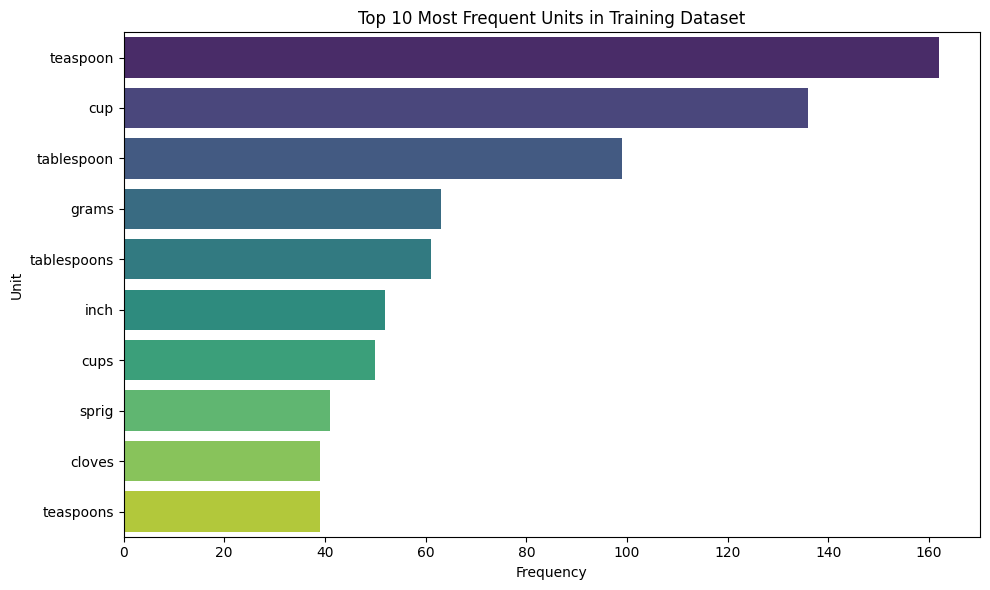

In [37]:
# plot the top frequent units in training data

top_train_units = get_top_frequent_items(train_units, 'Unit', dataset_name)

plot_top_items(top_train_units, 'Unit', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [38]:
# initialise the dataset_name


In [39]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [40]:
# plot the top frequent ingredients in validation data


In [41]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [42]:
# define unit and quantity keywords along with quantity pattern

unit_keywords = {
    "cup", "tablespoon", "cloves", "clove", "sprig", "piece", "pieces", "slice", "slices", "cups", "tablespoons", "teaspoon", "teaspoons", "tbsp", "tsp", "gram", "grams", "kg", "ml", "ltr", "litre", "litres", "ounce", "oz", "lb", "pinch", "dash",
}

quantity_keywords = {
    "five", "six", "seven", "eight", "nine", "ten", "dozen", "half", "quarter", "third", "one", "two", "three", "four"
}

quantity_patterns = [
    r"^\d+$",
    r"^\d+/\d+$",
    r"^\d+\.\d+$",
    r"^\d+-\d+/\d+$",
    r"^\d+\-\d+$",
    r"^\d+\sto\s\d+$"
]

# Compile patterns for faster use
compiled_quantity_patterns = [re.compile(p) for p in quantity_patterns]

# Example usage:
def is_quantity(token):
    return any(p.match(token) for p in compiled_quantity_patterns) or token.lower() in quantity_keywords

def is_unit(token):
    return token.lower() in unit_keywords

In [43]:
# load spaCy model

nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [44]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions


def word2features(sent, i, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns):
    word = sent[i]
    doc = nlp(" ".join(sent))
    token = doc[i]

    # --- Core Features ---
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word.isdigit()': word.isdigit(),
        'word.shape': token.shape_,
        'word.pos': token.pos_,
        'word.dep': token.dep_,
        'is_title': word.istitle(),
        'is_upper': word.isupper(),
        'is_alpha': word.isalpha(),
        'is_stop': token.is_stop,
    }

    # --- Improved Quantity & Unit Detection ---

    word_lower = word.lower()
    features['is_unit_keyword'] = word_lower in unit_keywords
    features['is_quantity_keyword'] = word_lower in quantity_keywords
    features['matches_quantity_pattern'] = any(p.match(word) for p in compiled_quantity_patterns)

    # --- Contextual Features ---

    if i > 0:
        prev_token = doc[i - 1]
        features.update({
            '-1:word.lower()': sent[i - 1].lower(),
            '-1:word.pos': prev_token.pos_,
            '-1:word.shape': prev_token.shape_,
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        next_token = doc[i + 1]
        features.update({
            '+1:word.lower()': sent[i + 1].lower(),
            '+1:word.pos': next_token.pos_,
            '+1:word.shape': next_token.shape_,
        })
    else:
        features['EOS'] = True

    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [45]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features

def sent2features(sent, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns):
    return [
        word2features(sent, i, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns)
        for i in range(len(sent))
    ]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [46]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features

X_train_features = [
    sent2features(sent, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns)
    for sent in X_train
]

X_val_features = [
    sent2features(sent, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns)
    for sent in X_val
]

print(f"Training feature sets: {len(X_train_features)}")
print(f"Validation feature sets: {len(X_val_features)}")

Training feature sets: 196
Validation feature sets: 84


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [47]:
# Convert labels into list as y_train_labels and y_val_labels

y_train_labels = [list(seq) for seq in y_train]
y_val_labels = [list(seq) for seq in y_val]

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [48]:
# print the length of train features and labels

print(f"Training features: {len(X_train_features)}")
print(f"Training labels: {len(y_train_labels)}")

Training features: 196
Training labels: 196


In [49]:
# print the length of validation features and labels

print(f"Validation features: {len(X_val_features)}")
print(f"Validation labels: {len(y_val_labels)}")

Validation features: 84
Validation labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [50]:
# Flatten labels in y_train

y_train_flat = [label for sublist in y_train for label in sublist]

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [51]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [52]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

weight_dict = {label: total_samples / count for label, count in label_counts.items()}

print("Class Weights (Inverse Frequency):")
for label, weight in weight_dict.items():
    print(f"{label}: {weight:.2f}")

Class Weights (Inverse Frequency):
quantity: 7.26
unit: 8.77
ingredient: 1.34


In [53]:
# penalise ingredient label

penalized_class_weights = weight_dict.copy()

if 'ingredient' in penalized_class_weights:
    penalized_class_weights['ingredient'] *= 0.5

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [54]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)

def extract_features_with_class_weights(X, y, weight_dict, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns):
    weighted_features = []

    for sent_tokens, sent_labels in zip(X, y):
        doc_features = []
        for i in range(len(sent_tokens)):
            base_features = word2features(sent_tokens, i, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns)
            label = sent_labels[i]
            weight = weight_dict.get(label, 1.0)
            # Apply weight to all numeric features
            weighted = {
                k: (v * weight if isinstance(v, (int, float)) else v)
                for k, v in base_features.items()
            }
            doc_features.append(weighted)
        weighted_features.append(doc_features)

    return weighted_features

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [55]:
# Apply manually computed class weights

# training data
X_train_weighted_features = extract_features_with_class_weights(X_train, y_train, penalized_class_weights, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns)

# validation data
X_val_weighted_features = extract_features_with_class_weights(X_val, y_val, penalized_class_weights, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns)


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [56]:
# initialise CRF model with the specified hyperparameters and use weight_dict

from sklearn_crfsuite import CRF
crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# train the CRF model with the weighted training data

crf.fit(X_train_weighted_features, y_train_labels)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [70]:
# evaluate on the training dataset

y_train_pred = crf.predict(X_train_weighted_features)

In [72]:
f1 = metrics.flat_f1_score(y_train_labels, y_train_pred, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.9991567676559567


In [73]:
# specify the flat classification report by using training data for evaluation

print(metrics.flat_classification_report(y_train_labels, y_train_pred))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      5323
    quantity       1.00      0.99      1.00       980
        unit       0.99      1.00      1.00       811

    accuracy                           1.00      7114
   macro avg       1.00      1.00      1.00      7114
weighted avg       1.00      1.00      1.00      7114



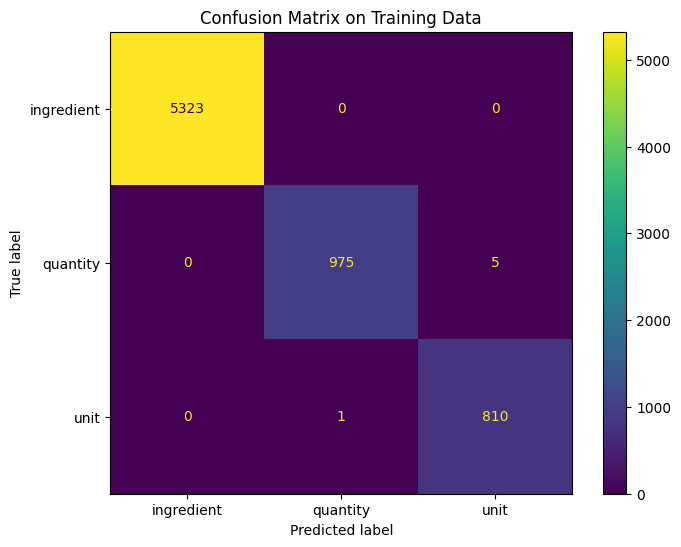

In [79]:
# create a confusion matrix on training datset

from sklearn.metrics import ConfusionMatrixDisplay

# get unique labels from the training data
labels = sorted(list(set(flatten_list(y_train_labels))))

# calculate confusion matrix for training data
cm_train = confusion_matrix(flatten_list(y_train_labels), flatten_list(y_train_pred), labels=labels)

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels).plot(ax=ax)
ax.set_title('Confusion Matrix on Training Data')
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [80]:
# dump the model using joblib as crf_model.pkl

joblib.dump(crf, 'crf_model.pkl')

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [81]:
# predict the crf model on validation dataset

y_val_pred = crf.predict(X_val_weighted_features)

In [83]:
# specify flat classification report

val_report = flat_classification_report(
    y_true=y_val_labels,
    y_pred=y_val_pred,
    digits=4,
    zero_division=0
)

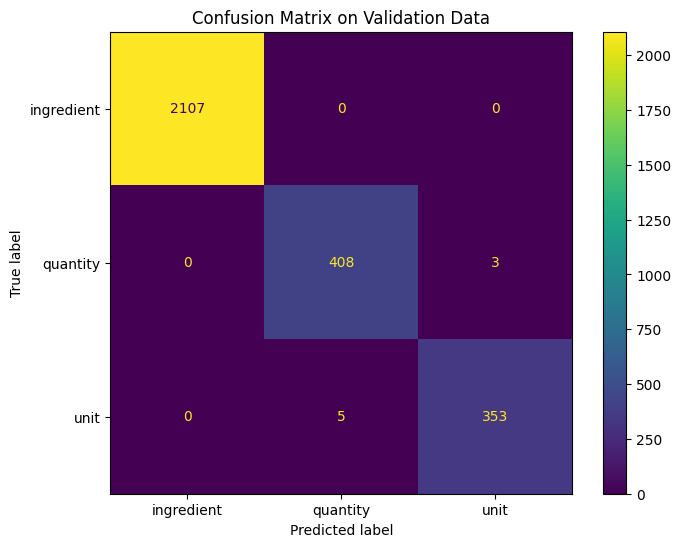

In [84]:
# create a confusion matrix on validation dataset

from sklearn.metrics import ConfusionMatrixDisplay

# get unique labels from the validation data
labels = sorted(list(set(flatten_list(y_val_labels))))

# calculate confusion matrix for validation data
cm_val = confusion_matrix(flatten_list(y_val_labels), flatten_list(y_val_pred), labels=labels)

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=labels).plot(ax=ax)
ax.set_title('Confusion Matrix on Validation Data')
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [86]:
# flatten Labels and Initialise Error Data

y_val_flat = [label for sublist in y_val_labels for label in sublist]
y_pred_val_flat = [label for sublist in y_val_pred for label in sublist]

error_data = []

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [89]:
# iterate and collect Error Information

for i, (tokens, true_labels, pred_labels) in enumerate(zip(X_val, y_val_labels, y_val_pred)):
    for j, (token, true_label, pred_label) in enumerate(zip(tokens, true_labels, pred_labels)):
        if true_label != pred_label:
            # get previous and next tokens with handling for boundary cases
            prev_token = tokens[j - 1] if j > 0 else None
            next_token = tokens[j + 1] if j < len(tokens) - 1 else None

            error_data.append({
                "sentence_index": i,
                "token_index": j,
                "token": token,
                "true_label": true_label,
                "predicted_label": pred_label,
                "previous_token": prev_token,
                "next_token": next_token
            })

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [92]:
# Create DataFrame and Print Overall Accuracy

from sklearn.metrics import accuracy_score

error_df = pd.DataFrame(error_data)
print("Overall Accuracy on Validation Set:")
print(accuracy_score(y_val_flat, y_pred_val_flat))

Overall Accuracy on Validation Set:
0.9972183588317107


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [93]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context


# Analyze errors by label type and display class weights and accuracy

# Calculate accuracy for each label (precision is used here as accuracy per predicted class)
label_accuracy = {}
for label in unique_y_train_labels_list:
    true_positives = sum(1 for t, p in zip(y_val_flat, y_pred_val_flat) if t == label and p == label)
    total_true = sum(1 for t in y_val_flat if t == label)
    label_accuracy[label] = true_positives / total_true if total_true > 0 else 0

print("\nError Analysis by True Label:")
for label in sorted(label_accuracy.keys()):
    print(f"Label: {label}")
    print(f"  Class Weight (Penalised): {penalized_class_weights.get(label, 1.0):.2f}")
    print(f"  Accuracy for {label}: {label_accuracy[label]:.4f}")

    # Display error examples for this label
    label_errors = error_df[error_df['true_label'] == label]
    if not label_errors.empty:
        print(f"  Misclassified examples for true label '{label}':")
        display(label_errors[['token', 'previous_token', 'next_token', 'true_label', 'predicted_label']].head())
    else:
        print(f"  No misclassified examples for true label '{label}'.")
    print("-" * 30)

print("\nFull Error DataFrame Head:")
display(error_df.head())


Error Analysis by True Label:
Label: ingredient
  Class Weight (Penalised): 0.67
  Accuracy for ingredient: 1.0000
  No misclassified examples for true label 'ingredient'.
------------------------------
Label: quantity
  Class Weight (Penalised): 7.26
  Accuracy for quantity: 0.9927
  Misclassified examples for true label 'quantity':


token previous_token   next_token true_label predicted_label
2     few      Pineapple  tablespoons   quantity            unit
6   pinch            Dal   Asafoetida   quantity            unit
7  cloves       Tomatoes       Garlic   quantity            unit

------------------------------
Label: unit
  Class Weight (Penalised): 8.77
  Accuracy for unit: 0.9860
  Misclassified examples for true label 'unit':


token previous_token next_token true_label predicted_label
0    to             10         12       unit        quantity
1  into            cut          1       unit        quantity
3  into            cut         cm       unit        quantity
4   and          Sweet      Spicy       unit        quantity
5     a          Haldi      pinch       unit        quantity

------------------------------

Full Error DataFrame Head:


sentence_index  token_index token true_label predicted_label previous_token   next_token
0              28            6    to       unit        quantity             10           12
1              28           12  into       unit        quantity            cut            1
2              28           70   few   quantity            unit      Pineapple  tablespoons
3              31            6  into       unit        quantity            cut           cm
4              31           34   and       unit        quantity          Sweet        Spicy

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

**Insights from the Validation Dataset:**

From the validation data analysis, we can observe the following insights:

1.  **Overall Performance:** The overall accuracy on the validation set provides a general sense of how well the model is performing on unseen data. Comparing this to the training accuracy (which is expected to be higher) indicates whether the model is overfitting or generalising well.

2.  **Label-Specific Performance:** The breakdown of accuracy and misclassified examples by the 'true_label' reveals which entity types the model struggles with the most.
    *   Labels with lower accuracy and a higher number of misclassified instances require further investigation. This could be due to:
        *   **Data Imbalance:** Some labels (like 'ingredient') might be much more frequent than others ('unit', 'quantity'), leading the model to favour the majority class. The penalised class weights were an attempt to mitigate this, but their impact should be evaluated.
        *   **Feature Limitations:** The current feature set might not adequately capture the characteristics that distinguish certain labels, especially in ambiguous contexts. For example, words that can be both an ingredient and a unit (e.g., "cup" as in "1 cup flour" vs. "add a cup") or ambiguous quantity terms might be challenging.
        *   **Contextual Ambiguity:** Some misclassifications might arise from the local context (previous and next tokens). Analysing the 'previous_token' and 'next_token' columns in the error DataFrame can highlight specific patterns where the model gets confused. For instance, a number followed by a word that *could* be a unit but is an ingredient might be misclassified.
        *   **Data Quality:** Examining the actual misclassified tokens and their surrounding context in the original 'input' string can reveal potential issues in the labelling of the validation data itself or edge cases in the data that the model hasn't learned to handle.

3.  **Impact of Class Weights:** Reviewing the class weights alongside the label accuracy helps understand if the weighting scheme effectively improved performance on minority classes or introduced new misclassification patterns for the majority class ('ingredient').

4.  **Common Error Patterns:** The error DataFrame, particularly looking at the 'token', 'previous_token', 'next_token', 'true_label', and 'predicted_label' columns for the misclassified examples, provides concrete instances of where the model fails. Identifying recurring patterns (e.g., misclassifying ingredients as units when they appear after numbers, or confusing certain quantities) can guide feature engineering improvements or targeted data augmentation.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.